## Importing the libraries

In [20]:
import os 
from dotenv import load_dotenv
load_dotenv()

from langgraph.graph import StateGraph , START , END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage , AIMessage , SystemMessage
from typing import TypedDict , Annotated
from pydantic import BaseModel , Field

In [21]:
model = ChatOpenAI(model="gpt-4.1-mini", temperature=0)

In [22]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma

## Create first database - about langgraph

In [23]:
urls=[
    "https://langchain-ai.github.io/langgraph/tutorials/introduction/",
    "https://langchain-ai.github.io/langgraph/tutorials/workflows/",
    "https://langchain-ai.github.io/langgraph/how-tos/map-reduce/"
]

docs=[WebBaseLoader(url).load() for url in urls]
docs

[[Document(metadata={'source': 'https://langchain-ai.github.io/langgraph/tutorials/introduction/', 'title': 'Redirecting...', 'language': 'en'}, page_content='\n\n\n\n\nRedirecting...\n\n\n\n\n\n\nRedirecting...\n\n\n')],
 [Document(metadata={'source': 'https://langchain-ai.github.io/langgraph/tutorials/workflows/', 'title': 'Redirecting...', 'language': 'en'}, page_content='\n\n\n\n\nRedirecting...\n\n\n\n\n\n\nRedirecting...\n\n\n')],
 [Document(metadata={'source': 'https://langchain-ai.github.io/langgraph/how-tos/map-reduce/', 'title': 'Redirecting...', 'language': 'en'}, page_content='\n\n\n\n\nRedirecting...\n\n\n\n\n\n\nRedirecting...\n\n\n')]]

In [24]:
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=100
)

doc_splits = text_splitter.split_documents(docs_list)

from langchain_openai import OpenAIEmbeddings
embeddings = OpenAIEmbeddings()

# ## Add alll these text to vectordb

# vectorstore=FAISS.from_documents(
#     documents=doc_splits,
#     embedding=OpenAIEmbeddings()
# )


# retriever=vectorstore.as_retriever()

# Save the vectorstore with a particular name, e.g., "bangladesh_economy"
db = Chroma.from_documents(doc_splits, embeddings, persist_directory="langgraph_documents")
langgraph_retriever = db.as_retriever(search_kwargs={"k": 3})

## Creating separate database - about langchain

In [25]:
langchain_urls=[
    "https://python.langchain.com/docs/tutorials/",
    "https://python.langchain.com/docs/tutorials/chatbot/",
    "https://python.langchain.com/docs/tutorials/qa_chat_history/"
]

docs=[WebBaseLoader(url).load() for url in langchain_urls]
docs

[[Document(metadata={'source': 'https://python.langchain.com/docs/tutorials/', 'title': 'Build a RAG agent with LangChain - Docs by LangChain', 'language': 'en'}, page_content='Build a RAG agent with LangChain - Docs by LangChainSkip to main contentWe\'ve raised a $125M Series B to build the platform for agent engineering. Read more.Docs by LangChain home pageLangChain + LangGraphSearch...⌘KAsk AIGitHubTry LangSmithTry LangSmithSearch...NavigationLangChainBuild a RAG agent with LangChainLangChainLangGraphDeep AgentsIntegrationsLearnReferenceContributePythonLearnTutorialsLangChainSemantic searchRAG agentSQL agentSupervisor agentLangGraphConceptual overviewsMemoryContextGraph APIFunctional APIAdditional resourcesLangChain AcademyCase studiesEnglishcloseOn this pageOverviewConceptsPreviewSetupInstallationLangSmithComponents1. IndexingLoading documentsSplitting documentsStoring documents2. Retrieval and GenerationRAG agentsRAG chainsNext stepsTutorialsLangChainBuild a RAG agent with LangCh

In [26]:
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=100
)

doc_splits = text_splitter.split_documents(docs_list)

from langchain_openai import OpenAIEmbeddings
embeddings = OpenAIEmbeddings()

# ## Add alll these text to vectordb

# vectorstore=FAISS.from_documents(
#     documents=doc_splits,
#     embedding=OpenAIEmbeddings()
# )


# retriever=vectorstore.as_retriever()

# Save the vectorstore with a particular name, e.g., "bangladesh_economy"
db = Chroma.from_documents(doc_splits, embeddings, persist_directory="langchain_documents")
langchain_retriever = db.as_retriever(search_kwargs={"k": 3})

## create a tool out of both

In [27]:
### Retriever To Retriever Tools
from langchain.tools.retriever import create_retriever_tool

langgraph_retriever_tool=create_retriever_tool(
    langgraph_retriever,
    "retriever_langgraph",
    "Search and run information about Langgraph saved in the documents"
)

In [28]:
from langchain.tools.retriever import create_retriever_tool

langchain_retriever_tool=create_retriever_tool(
    langchain_retriever,
    "retriever_langchain",
    "Search and run information about Langchain saved in the documents"
)

In [29]:
tool_list = [langgraph_retriever_tool , langchain_retriever_tool]

In [30]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

## Define Nodes

In [31]:
def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    llm_with_tools = model.bind_tools(tool_list)
    response = llm_with_tools.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [32]:
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict
from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field

In [33]:
### Edges
def grade_documents(state) -> Literal["generate_tool", "rewrite_tool"]:
    """
    Determines whether the retrieved documents are relevant to the question.
    If documents are not relevant and retry limit reached, generates anyway.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")
    
    # Check retry limit first
    retry_count = state.get("retry_count", 0)
    MAX_RETRIES = 2  # Maximum number of rewrite attempts

    def format_docs(docs):
        return "\n\n".join(doc for doc in docs)

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM with tool and validation
    grading_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.
        """,
        input_variables=["context", "question"],
        validate_template=True)
        
    # Chain
    chain = prompt | grading_tool

    question = state["messages"][0].content
    docs = state["messages"][-1].content
    refined_docs = format_docs(docs)

    scored_result = chain.invoke({"question": question, "context": refined_docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate_tool"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite_tool"

In [34]:
def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated message
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | model | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

In [35]:
def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    response = model.invoke(msg)
    return {"messages": [response]}

In [36]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
# workflow.add_node("retrieve_tools" , ToolNode(tool_list))
retrieve_tools = ToolNode(tool_list)
workflow.add_node("retrieve", retrieve_tools)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node("generate", generate) 

workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    "agent",
    tools_condition,
    {
        "tools": "retrieve",
        END: END,
    }
)
# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    grade_documents,
    {
        "generate_tool": "generate",
        "rewrite_tool": "rewrite"
    }
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

graph = workflow.compile()



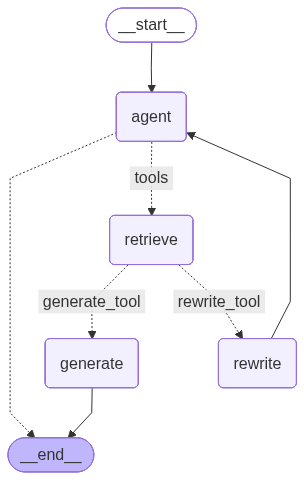

In [37]:
# Compile
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [38]:
graph.invoke({"messages":"What is Langchain?"})

---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


{'messages': [HumanMessage(content='What is Langchain?', additional_kwargs={}, response_metadata={}, id='23a123f9-4d8f-46e3-b7a3-b0f6bb731246'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_43VYhByaAwylPJh8PldYj3o7', 'function': {'arguments': '{"query":"What is Langchain?"}', 'name': 'retriever_langchain'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 102, 'total_tokens': 123, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_4c2851f862', 'id': 'chatcmpl-CZKJZFftm96gJwoQAXm5LS4wEvPY4', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--c33e6b5b-9aef-44ca-bbdc-fba6db3d3703-0', tool_calls=[{'name': 'retriever_langchain', 'args': {'query':

In [42]:
graph.invoke({"messages":"what is diff between workflow and agents?"})

---CALL AGENT---


{'messages': [HumanMessage(content='what is diff between workflow and agents?', additional_kwargs={}, response_metadata={}, id='90a28d6c-c6ac-4235-93ae-802e3514dbc9'),
  AIMessage(content='The difference between workflows and agents generally lies in their purpose and functionality:\n\n1. Workflow:\n- A workflow is a defined sequence of steps or tasks designed to accomplish a specific process or goal.\n- It represents a structured flow of activities, often automated, that guide how work is done from start to finish.\n- Workflows are typically used to orchestrate multiple actions, data processing, or decision points in a systematic manner.\n- They can be linear or complex with branching, loops, and conditional logic.\n- Example: An approval workflow where a document is submitted, reviewed, approved, or rejected in stages.\n\n2. Agents:\n- Agents are autonomous entities or programs that perform tasks on behalf of a user or system.\n- They can perceive their environment, make decisions, a

In [43]:
response = graph.invoke({"messages":"What is map reduce?"})

---CALL AGENT---


In [44]:
response["messages"][-1].content

'MapReduce is a programming model and processing technique used for processing and generating large data sets with a parallel, distributed algorithm on a cluster. It consists of two main functions:\n\n1. Map: The map function takes an input pair and produces a set of intermediate key-value pairs. The map function processes the input data and transforms it into a format suitable for the next step.\n\n2. Reduce: The reduce function takes the intermediate key-value pairs produced by the map function and merges them to form a smaller set of values. The reduce function aggregates, summarizes, or otherwise processes the data to produce the final output.\n\nMapReduce is widely used in big data processing frameworks like Hadoop to efficiently process large volumes of data by distributing the workload across multiple nodes in a cluster. It enables parallel processing, fault tolerance, and scalability.'